In [71]:
import numpy as np
import os
import PIL
import PIL.Image
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets.public_api as tfds
import pathlib
from tensorflow_datasets.datasets.oxford_flowers102 import oxford_flowers102_dataset_builder as OF
from tensorflow.keras import optimizers,losses
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import regularizers
from keras.utils import plot_model

In [72]:
dataset, dataset_info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)

In [73]:
IMAGE_RES = 224
height = 224
width = 224

def imageFormating(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label

In [74]:
def imageNormalization(images, a=-1, b=1, minPix=[0], maxPix=[255]):
    a = tf.constant([a], dtype=tf.float32)
    b = tf.constant([b], dtype=tf.float32)
    min_pixel = tf.constant(minPix, dtype=tf.float32)
    max_pixel = tf.constant(maxPix, dtype=tf.float32)

    return a + (((images - min_pixel)*(b - a) )/(max_pixel - min_pixel))

In [75]:
def flipGraph(x):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    return x
     
def rotateGraph(x):
    return tf.image.rot90(x, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
     
def dataPreprocess(*vals):
    features = ImageNormalization(resize_image(vals[0]))
    labels = oneHotEncode(vals[1], no_classes)
    return features, labels

In [76]:
def dataAugmentation(*vals):

    features = centerCrop(rotateGraph(flipGraph(imageNormalization(iamgeResize(vals[0])))))
    labels = oneHotEncode(vals[1], no_classes)
    return features, labels


In [77]:
def iamgeResize(image, size=(224,224)):
    return tf.image.resize(image, size)

In [78]:
def oneHotEncode(labels, no_classes):
    return tf.one_hot(labels, no_classes)

In [79]:
def centerCrop(img):

    h, w = img.shape[0], img.shape[1]
    m = min(h, w)
    cropped_img = img[(h-m)//2:(h+m)//2, (w-m)//2:(w+m)//2, :]

    return cropped_img

In [80]:
LR = 0.001

def updateLR(epoch, learnRate):
  if(epoch > 450):
    learnRate = 0.000005
  elif(epoch > 350):
    learnRate = 0.00005

  elif(epoch > 200):
    learnRate = 0.0001

  elif(epoch > 100):
    learnRate = 0.0005
    

  return learnRate

callbackLr = tf.keras.callbacks.LearningRateScheduler(updateLR, verbose=1)

In [81]:
batchSize = 32

bufferSize = 500

trainDataset = dataset['train'].shuffle(bufferSize).map(dataAugmentation).batch(batchSize).prefetch(1)
# set the test data set
testDataset = dataset['test'].map(dataAugmentation).batch(batchSize).prefetch(1)
# set the validation data set
validationDataset = dataset['validation'].map(dataAugmentation).batch(batchSize).prefetch(1)

In [82]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape = (224,224,3),padding='same',strides = 2,dilation_rate = 1,use_bias = True),
    tf.keras.layers.BatchNormalization(),
    

    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu',padding='same',strides = 2,dilation_rate = 1,use_bias = True),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.BatchNormalization(),


    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu',padding='same',strides = 2, dilation_rate = 1,use_bias = True),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu',kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.001),),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(102, activation='softmax',kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.001),),
    
])

In [83]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

In [84]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(trainDataset,
                    epochs=300,
                    validation_data=validationDataset,
                   callbacks=[early_stopping, callbackLr])


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/300
32/32 [==============================] - 6s 146ms/step - loss: 6.7601 - accuracy: 0.0314 - val_loss: 6.1780 - val_accuracy: 0.0118 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/300
32/32 [==============================] - 5s 140ms/step - loss: 5.6069 - accuracy: 0.1069 - val_loss: 6.4475 - val_accuracy: 0.0186 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/300
32/32 [==============================] - 5s 143ms/step - loss: 5.1067 - accuracy: 0.1784 - val_loss: 6.6218 - val_accuracy: 0.0324 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/300
32/32 [==============================] - 5s 145ms/step - loss: 4.9014 - accuracy: 0.2059 - val_loss: 6.9627 - val_accuracy: 0.0265 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to

In [88]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 112, 112, 32)      896       
                                                                 
 batch_normalization_21 (Bat  (None, 112, 112, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_22 (Bat  (None, 56, 56, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 64)        18496     
                                                      

In [89]:
results = model.evaluate(testDataset, batch_size=32)
print("test loss, test acc:", results)

193/193 [==============================] - 8s 41ms/step - loss: 2.3973 - accuracy: 0.5185
test loss, test acc: [2.397336006164551, 0.5184583067893982]


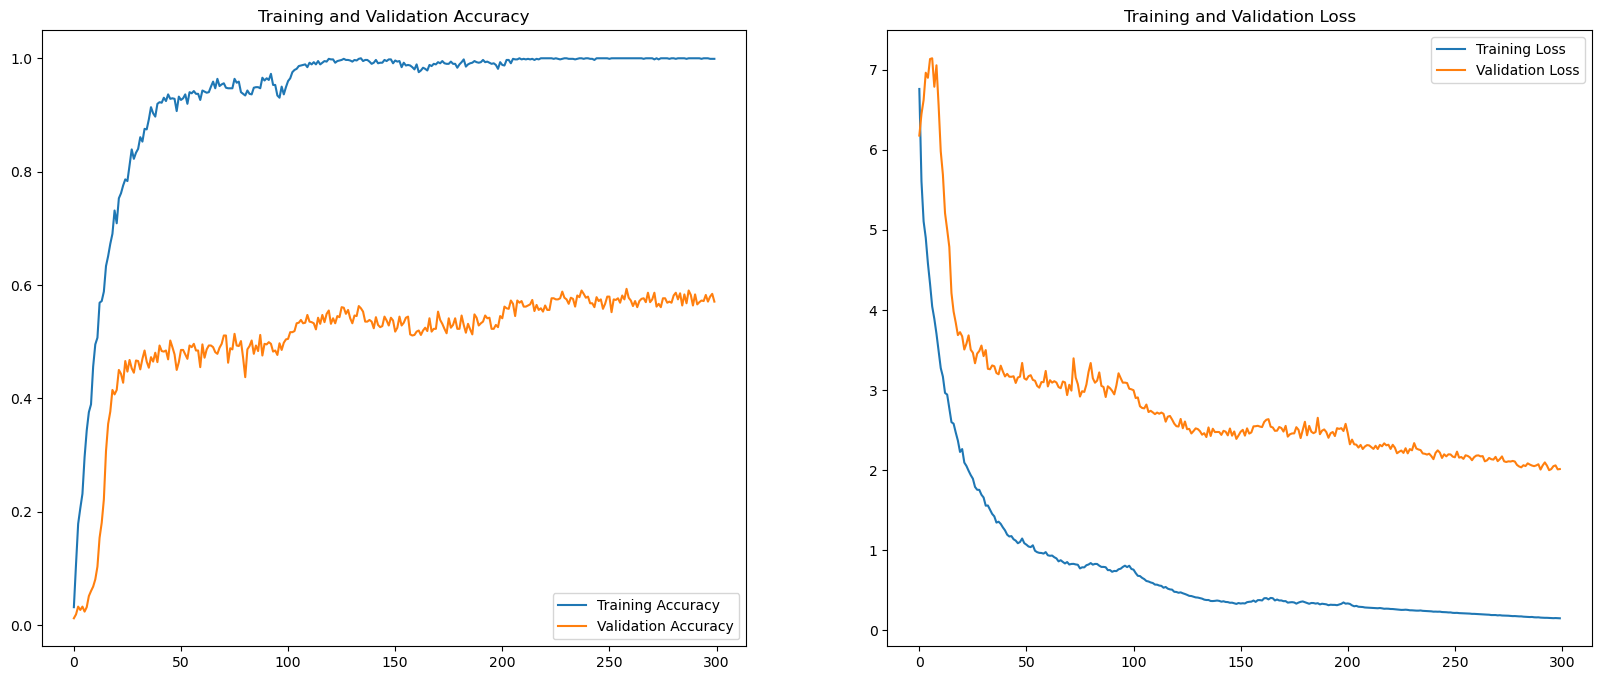

In [90]:
trainLoss = history.history['loss']
valLoss = history.history['val_loss']

trainAcc = history.history['accuracy']
valAcc = history.history['val_accuracy']

epochs = range(300)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, trainAcc, label='Training Accuracy')
plt.plot(epochs, valAcc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, trainLoss, label='Training Loss')
plt.plot(epochs, valLoss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
     

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [92]:
model.save("CNN_model.keras")